In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import os
from PIL import Image
import numpy as np

DATA_DIR = './'
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
LABELS_CSV = os.path.join(DATA_DIR, 'train_labels.csv')
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test')

# データ拡張（学習時のみ）
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PCamDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None):
        self.img_dir = img_dir
        self.labels = labels_df
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx, 0]
        label = self.labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

labels_df = pd.read_csv(LABELS_CSV)
train_df, val_df = train_test_split(labels_df, test_size=0.1, random_state=42, stratify=labels_df['label'])

train_dataset = PCamDataset(TRAIN_IMG_DIR, train_df, train_transform)
val_dataset = PCamDataset(TRAIN_IMG_DIR, val_df, val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

resnet50.fc = nn.Linear(resnet50.fc.in_features, 1)
model = resnet50.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# EarlyStopping & モデル保存
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0
        self.delta = delta
        self.best_model = None
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.best_model = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model = model.state_dict()
            self.counter = 0

early_stopping = EarlyStopping(patience=7, verbose=True)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # 検証
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)
            outputs = model(images).squeeze()
            preds = torch.sigmoid(outputs) > 0.5
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_acc = accuracy_score(val_labels, val_preds)
    print(f'Val Accuracy: {val_acc*100:.2f}%')
    early_stopping(val_acc, model)
    if early_stopping.early_stop:
        print('Early stopping!')
        break

# 最良モデル復元
model.load_state_dict(early_stopping.best_model)

# テストデータ予測（TTA: 画像反転で平均化）
test_img_names = os.listdir(TEST_IMG_DIR)
test_preds = []
model.eval()
for img_name in test_img_names:
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    img = Image.open(img_path)
    tensors = []
    for flip in [None, 'H', 'V']:
        aug_img = img
        if flip == 'H':
            aug_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        elif flip == 'V':
            aug_img = img.transpose(Image.FLIP_TOP_BOTTOM)
        tensor = val_transform(aug_img).unsqueeze(0).to(device)
        tensors.append(tensor)
    with torch.no_grad():
        outputs = [torch.sigmoid(model(t)).item() for t in tensors]
        pred = np.mean(outputs)
        test_preds.append(pred)

# 予測結果をCSVに保存
submission = pd.DataFrame({
    'id': [os.path.splitext(name)[0] for name in test_img_names],
    'label': test_preds
})
submission.to_csv('submission.csv', index=False)
print('submission.csvを保存しました')

Epoch 1/30, Loss: 0.1926
Val Accuracy: 96.05%
Val Accuracy: 96.05%
Epoch 2/30, Loss: 0.1242
Epoch 2/30, Loss: 0.1242
Val Accuracy: 96.80%
Val Accuracy: 96.80%
Epoch 3/30, Loss: 0.1006
Epoch 3/30, Loss: 0.1006
Val Accuracy: 97.35%
Val Accuracy: 97.35%
Epoch 4/30, Loss: 0.0873
Epoch 4/30, Loss: 0.0873
Val Accuracy: 97.31%
EarlyStopping counter: 1 out of 7
Val Accuracy: 97.31%
EarlyStopping counter: 1 out of 7
Epoch 5/30, Loss: 0.0765
Epoch 5/30, Loss: 0.0765
Val Accuracy: 97.70%
Val Accuracy: 97.70%
Epoch 6/30, Loss: 0.0694
Epoch 6/30, Loss: 0.0694
Val Accuracy: 97.75%
Val Accuracy: 97.75%
Epoch 7/30, Loss: 0.0630
Epoch 7/30, Loss: 0.0630
Val Accuracy: 97.77%
Val Accuracy: 97.77%
Epoch 8/30, Loss: 0.0580
Epoch 8/30, Loss: 0.0580
Val Accuracy: 97.85%
Val Accuracy: 97.85%
Epoch 9/30, Loss: 0.0538
Epoch 9/30, Loss: 0.0538
Val Accuracy: 97.89%
Val Accuracy: 97.89%
Epoch 10/30, Loss: 0.0488
Epoch 10/30, Loss: 0.0488
Val Accuracy: 97.71%
EarlyStopping counter: 1 out of 7
Val Accuracy: 97.71%
E

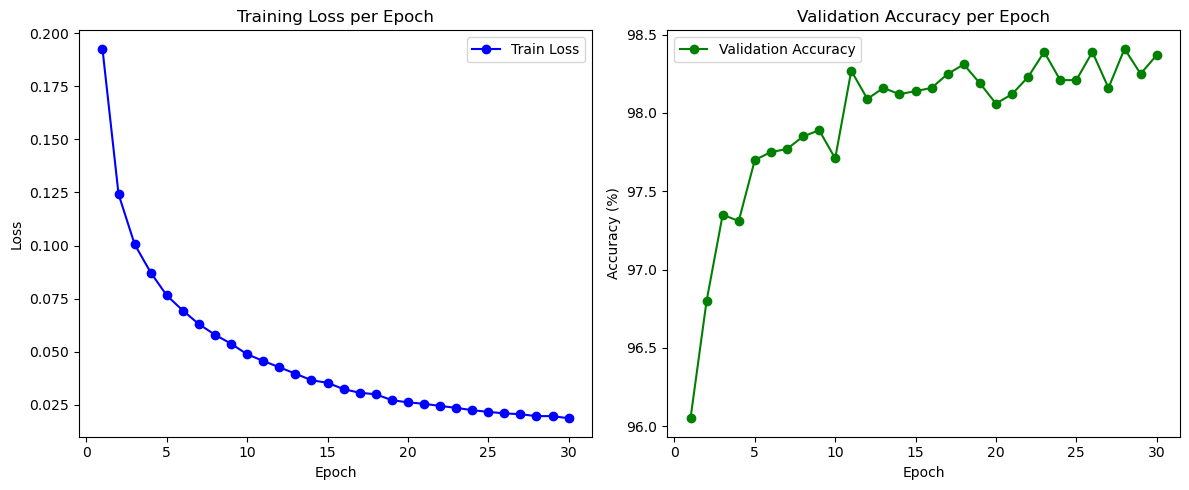

In [3]:
import matplotlib.pyplot as plt

# ログから抽出した数値
epochs = list(range(1, 31))
losses = [
    0.1926, 0.1242, 0.1006, 0.0873, 0.0765, 0.0694, 0.0630, 0.0580, 0.0538, 0.0488,
    0.0457, 0.0427, 0.0397, 0.0366, 0.0354, 0.0324, 0.0307, 0.0300, 0.0272, 0.0262,
    0.0255, 0.0245, 0.0236, 0.0225, 0.0217, 0.0210, 0.0206, 0.0197, 0.0197, 0.0187
]
val_acc = [
    96.05, 96.80, 97.35, 97.31, 97.70, 97.75, 97.77, 97.85, 97.89, 97.71,
    98.27, 98.09, 98.16, 98.12, 98.14, 98.16, 98.25, 98.31, 98.19, 98.06,
    98.12, 98.23, 98.39, 98.21, 98.21, 98.39, 98.16, 98.41, 98.25, 98.37
]

# グラフの描画
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, losses, marker='o', color='blue', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, val_acc, marker='o', color='green', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()
